In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn.init as init
from torch.autograd import Variable, grad
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import numpy as np
import random
import torch.nn.utils
from tqdm import tqdm
from typing import Iterable
from copy import deepcopy
import seaborn as sns

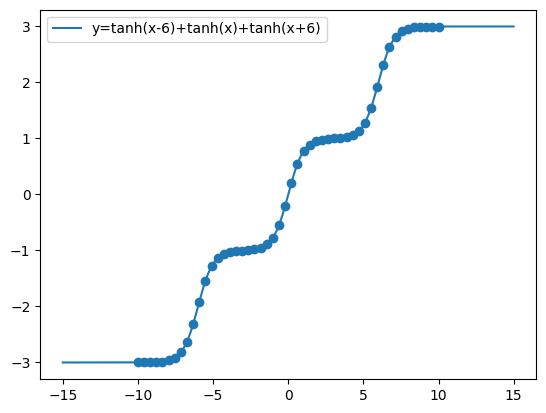

In [26]:
dtype=torch.float32
def fstar(x):
    if type(x)==torch.Tensor:
        return torch.tanh(x-6)+torch.tanh(x)+torch.tanh(x+6)
    if type(x)==np.ndarray:
        return np.tanh(x-6)+np.tanh(x)+np.tanh(x+6)
x = torch.unsqueeze(torch.linspace(-10,10,50,dtype=dtype),dim=1)
x1 = torch.unsqueeze(torch.linspace(-15,15,50,dtype=dtype),dim=1)
y = fstar(x)
x , y =(Variable(x),Variable(y))
x_plot=np.linspace(-15,15,1000)
y_plot=fstar(x_plot)
plt.scatter(x.data,y.data)
plt.plot(x_plot,y_plot,label='y=tanh(x-6)+tanh(x)+tanh(x+6)')
# 或者采用如下的方式也可以输出x,y
# plt.scatter(x.data.numpy(),y.data.numpy())
plt.legend()
plt.show()


In [3]:
# 设备的交代和误差函数的定义
loss_func = torch.nn.MSELoss()
        

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


### 下面是一些神经网络类的定义

In [4]:
#几个神经网络类的定义
class Net1(nn.Module):
    def __init__(self,n_input,n_hidden,n_output,linear=False):
        super(Net1,self).__init__()
        self.hidden1 = nn.Linear(n_input,n_hidden)
        self.predict = nn.Linear(n_hidden,n_output,bias=False)
        self.linear=linear
    def forward(self,input):
        out = self.hidden1(input)
        if self.linear==False:
            out = F.tanh(out)
        out =self.predict(out)
        return out
    
class Net2(nn.Module):
    def __init__(self,n_input,n_hidden1, n_hidden2,n_output,linear=False):
        super(Net2,self).__init__()
        self.hidden1 = nn.Linear(n_input,n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.predict = nn.Linear(n_hidden2,n_output,bias=False)
        self.linear=linear
    def forward(self,input):
        out = self.hidden1(input)
        if self.linear==False:
            out = F.tanh(out)
        out = self.hidden2(out)
        if self.linear==False:
            out = F.tanh(out)
        out =self.predict(out)
        return out

In [5]:
# 一个全连接层一个卷积层的神经网络
class CNN1(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, linear=False):
        super(CNN1, self).__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        # 确保卷积层的in_channels与n_hidden一致
        self.c1 = nn.Conv1d(1, 1, 3, 1, 1)  # 假设输入的channels为1，调整为正确的值
        self.l2 = nn.Linear(n_hidden, n_output, bias=False)
        self.linear = linear

    def forward(self, x):
        x = self.l1(x)
        x = F.tanh(x)
        # 重新排列x以匹配Conv1d的期望输入形状[batch_size, channels, length]
        # 这里假设x的最后一个维度是时间或序列维度
        x = x.unsqueeze(1)
        # print(x.size())
        x = self.c1(x)
        x = F.tanh(x)
        # 在传递给最后一个线性层之前，可能需要调整x的形状
        x = x.view(x.size(0), -1)  # 展平除了batch_size以外的所有维度
        x = self.l2(x)
        return x
    def MPC1(self, input):
        out1 = self.l1(input)
        out2 = F.tanh(out1)
        mid = torch.sum(out1 * out2, dim=0)
        down = torch.norm(out1,p=2,dim=0) * torch.norm(out2, p=2, dim=0)
        return torch.min(mid / down)
    def MPC2(self, input):
        x = self.l1(input)
        x = F.tanh(x)
        # 重新排列x以匹配Conv1d的期望输入形状[batch_size, channels, length]
        # 这里假设x的最后一个维度是时间或序列维度
        x = x.unsqueeze(1)
        # print(x.size())
        x = self.c1(x)
        out1 = x.view(x.size(0), -1)
        out2 = F.tanh(out1)
        mid = torch.sum(out1 * out2, dim=0)
        down = torch.norm(out1,p=2,dim=0) * torch.norm(out2, p=2, dim=0)
        return torch.min(mid / down)

In [6]:
# 两个个全连接层一个卷积层的神经网络
class CNN3(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output, linear=False):
        super(CNN3, self).__init__()
        self.l1 = nn.Linear(n_input, n_hidden1)
        self.l2 = nn.Linear(n_hidden1,n_hidden2)
        # 确保卷积层的in_channels与n_hidden一致
        self.c1 = nn.Conv1d(1, 1, 3, 1, 1)  # 假设输入的channels为1，调整为正确的值
        self.l3 = nn.Linear(n_hidden2, n_output, bias=False)
        self.linear = linear

    def forward(self, x):
        x = self.l1(x)
        x = F.tanh(x)
        x = self.l2(x)
        x = F.tanh(x)
        # 重新排列x以匹配Conv1d的期望输入形状[batch_size, channels, length]
        # 这里假设x的最后一个维度是时间或序列维度
        x = x.unsqueeze(1)
        # print(x.size())
        x = self.c1(x)
        x = F.tanh(x)
        # 在传递给最后一个线性层之前，可能需要调整x的形状
        x = x.view(x.size(0), -1)  # 展平除了batch_size以外的所有维度
        x = self.l3(x)
        return x
    def MPC1(self, input):
        out1 = self.l1(input)
        out2 = F.tanh(out1)
        mid = torch.sum(out1 * out2, dim=0)
        down = torch.norm(out1,p=2,dim=0) * torch.norm(out2, p=2, dim=0)
        return torch.min(mid / down)
    def MPC2(self, input):
        out = self.l1(input)
        if self.linear==False:
            out = F.tanh(out)
        out1 = self.l2(out)
        out2 = F.tanh(out1)
        mid = torch.sum(out1 * out2, dim=0)
        down = torch.norm(out1,p=2,dim=0) * torch.norm(out2, p=2, dim=0)
        return torch.min(mid / down)
    def MPC3(self, input):
        x = self.l1(input)
        x = F.tanh(x)
        x = self.l2(x)
        x = F.tanh(x)
        # 重新排列x以匹配Conv1d的期望输入形状[batch_size, channels, length]
        # 这里假设x的最后一个维度是时间或序列维度
        x = x.unsqueeze(1)
        # print(x.size())
        x = self.c1(x)
        out1 = x.view(x.size(0), -1)
        out2 = F.tanh(out1)
        mid = torch.sum(out1 * out2, dim=0)
        down = torch.norm(out1,p=2,dim=0) * torch.norm(out2, p=2, dim=0)
        return torch.min(mid / down)

In [7]:
# 一个全连接层两个卷积层的神经网络
class CNN5(nn.Module):
    def __init__(self, n_input, n_hidden1, n_output, linear=False):
        super(CNN5, self).__init__()
        self.l1 = nn.Linear(n_input, n_hidden1)
        self.c1 = nn.Conv1d(1, 1, 3, 1, 1)  # 假设输入的channels为1，调整为正确的值
        self.c2 = nn.Conv1d(1, 1, 3, 1, 1)
        # 确保卷积层的in_channels与n_hidden一致
        self.l2 = nn.Linear(n_hidden1, n_output, bias=False)
        self.linear = linear

    def forward(self, x):
        x = self.l1(x)
        x = F.tanh(x)
        x = x.unsqueeze(1)
        # print(x.size())
        x = self.c1(x)
        x = F.tanh(x)
        x = x.view(x.size(0), -1)  # 展平除了batch_size以外的所有维度
        x = x.unsqueeze(1)
        # print(x.size())
        x = self.c2(x)
        x = x.view(x.size(0), -1)
        x = F.tanh(x)
        x = self.l2(x)
        return x
    def MPC1(self, input):
        out1 = self.l1(input)
        out2 = F.tanh(out1)
        mid = torch.sum(out1 * out2, dim=0)
        down = torch.norm(out1,p=2,dim=0) * torch.norm(out2, p=2, dim=0)
        return torch.min(mid / down)
    def MPC2(self, input):
        x = self.l1(input)
        x = F.tanh(x)
        x = x.unsqueeze(1)
        # print(x.size())
        x = self.c1(x)
        out1 = x.view(x.size(0), -1)
        out2 = F.tanh(out1)
        mid = torch.sum(out1 * out2, dim=0)
        down = torch.norm(out1,p=2,dim=0) * torch.norm(out2, p=2, dim=0)
        return torch.min(mid / down)
    def MPC3(self, input):
        x = self.l1(input)
        x = F.tanh(x)
        x = x.unsqueeze(1)
        # print(x.size())
        x = self.c1(x)
        x = x.view(x.size(0), -1)
        x = F.tanh(x)
        x = x.unsqueeze(1)
        x = self.c2(x)
        x = x.view(x.size(0), -1)
        out1 = x
        out2 = F.tanh(out1)
        mid = torch.sum(out1 * out2, dim=0)
        down = torch.norm(out1,p=2,dim=0) * torch.norm(out2, p=2, dim=0)
        return torch.min(mid / down)

In [67]:
# 一个全连接层四个卷积层的神经网络
class CNN6(nn.Module):
    def __init__(self, n_input, n_hidden1, n_output, linear=False):
        super(CNN6, self).__init__()
        self.l1 = nn.Linear(n_input, n_hidden1)
        self.c1 = nn.Conv1d(1, 1, 3, 1, 1)  # 假设输入的channels为1，调整为正确的值
        self.c2 = nn.Conv1d(1, 1, 3, 1, 1)
        self.c3 = nn.Conv1d(1, 1, 3, 1, 1)
        self.c4 = nn.Conv1d(1, 1, 3, 1, 1)
        # 确保卷积层的in_channels与n_hidden一致
        self.l2 = nn.Linear(n_hidden1, n_output, bias=False)
        self.linear = linear

    def forward(self, x):
        x = self.l1(x)
        x = F.tanh(x)
        x = x.unsqueeze(1)
        # print(x.size())
        x = self.c1(x)
        x = F.tanh(x)
        x = x.view(x.size(0), -1)  # 展平除了batch_size以外的所有维度
        x = x.unsqueeze(1)
        x = self.c2(x)
        x = F.tanh(x)
        x = self.c3(x)
        x = F.tanh(x)
        x = self.c4(x)
        x = x.view(x.size(0), -1)
        x = F.tanh(x)
        x = self.l2(x)
        return x
    def MPC1(self, input):
        out1 = self.l1(input)
        out2 = F.tanh(out1)
        mid = torch.sum(out1 * out2, dim=0)
        down = torch.norm(out1,p=2,dim=0) * torch.norm(out2, p=2, dim=0)
        return torch.min(mid / down)
    def MPC2(self, input):
        x = self.l1(input)
        x = F.tanh(x)
        x = x.unsqueeze(1)
        # print(x.size())
        x = self.c1(x)
        out1 = x.view(x.size(0), -1)
        out2 = F.tanh(out1)
        mid = torch.sum(out1 * out2, dim=0)
        down = torch.norm(out1,p=2,dim=0) * torch.norm(out2, p=2, dim=0)
        return torch.min(mid / down)
    def MPC3(self, input):
        x = self.l1(input)
        x = F.tanh(x)
        x = x.unsqueeze(1)
        # print(x.size())
        x = self.c1(x)
        x = x.view(x.size(0), -1)
        x = F.tanh(x)
        x = x.unsqueeze(1)
        x = self.c2(x)
        x = x.view(x.size(0), -1)
        out1 = x
        out2 = F.tanh(out1)
        mid = torch.sum(out1 * out2, dim=0)
        down = torch.norm(out1,p=2,dim=0) * torch.norm(out2, p=2, dim=0)
        return torch.min(mid / down)
    def MPC4(self, input):
        x = self.l1(input)
        x = F.tanh(x)
        x = x.unsqueeze(1)
        # print(x.size())
        x = self.c1(x)
        x = x.view(x.size(0), -1)
        x = F.tanh(x)
        x = x.unsqueeze(1)
        x = self.c2(x)
        x = F.tanh(x)
        x = self.c3(x)
        x = x.view(x.size(0), -1)
        out1 = x
        out2 = F.tanh(out1)
        mid = torch.sum(out1 * out2, dim=0)
        down = torch.norm(out1,p=2,dim=0) * torch.norm(out2, p=2, dim=0)
        return torch.min(mid / down)
    def MPC5(self, input):
        x = self.l1(input)
        x = F.tanh(x)
        x = x.unsqueeze(1)
        # print(x.size())
        x = self.c1(x)
        x = x.view(x.size(0), -1)
        x = F.tanh(x)
        x = x.unsqueeze(1)
        x = self.c2(x)
        x = F.tanh(x)
        x = self.c3(x)
        x = F.tanh(x)
        x = self.c4(x)
        x = x.view(x.size(0), -1)
        out1 = x
        out2 = F.tanh(out1)
        mid = torch.sum(out1 * out2, dim=0)
        down = torch.norm(out1,p=2,dim=0) * torch.norm(out2, p=2, dim=0)
        return torch.min(mid / down)

100%|██████████| 200000/200000 [06:10<00:00, 540.37it/s]


Text(0, 0.5, 'loss')

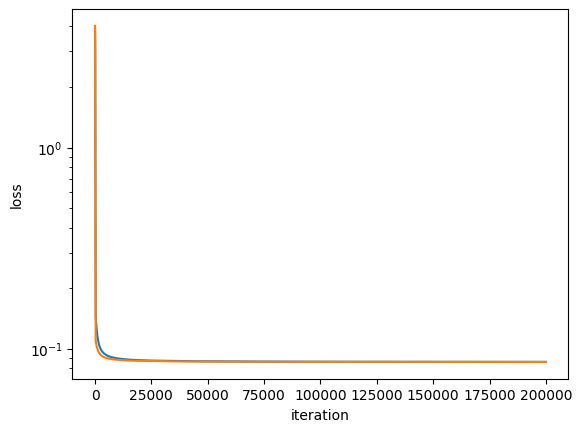

In [8]:
## 全连接网络
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std= 10**(-2))
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
iterations=round(2*10**(5))
xx=np.linspace(1,iterations+1,iterations)
net1 = Net1(1,50,1,linear=False)
net1.apply(weights_init)
net1 = net1.to(device)
optimizer1 = torch.optim.SGD(net1.parameters(),lr = 0.001)
all_loss1 = []
net3 = CNN1(1,50,1,linear=False) 
net3.apply(weights_init)
net3=net3.to(device)    
optimizer3 = torch.optim.SGD(net3.parameters(),lr = 0.001)
all_loss3=[]
mpc1 = []
mpc2 = []
para=np.zeros((iterations,3))
for t in tqdm(range(iterations)):
    if t%200==0:
        mpc1.append(net3.MPC1(x.to(device)).item())
        mpc2.append(net3.MPC2(x.to(device)).item())
    net1 = net1.to(device)
    prediction1 = net1(x.to(device))
    loss1 = loss_func(prediction1, y.to(device))
    all_loss1.append(loss1.item())
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()  
    net3=net3.to(device)
    prediction3 = net3(x.to(device))
    loss3 = loss_func(prediction3,y.to(device))
    all_loss3.append(loss3.item())
    optimizer3.zero_grad()
    loss3.backward()
    optimizer3.step()  
    pass    


plt.plot(xx, all_loss3)
plt.plot(xx, all_loss1)
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('loss')

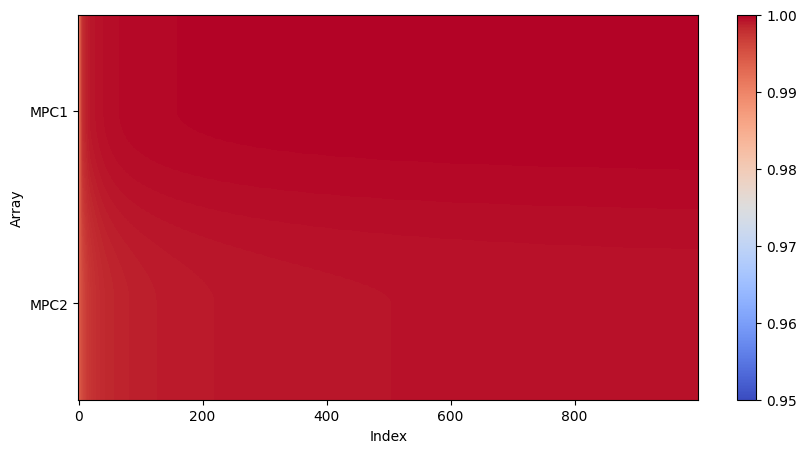

In [9]:
# 将列表转换为 NumPy 数组
mpc1_array = np.array(mpc1)
mpc2_array = np.array(mpc2)

# 垂直堆叠这两个数组
matrix = np.vstack([mpc1_array, mpc2_array])

# 绘制热力图
plt.figure(figsize=(10, 5))  # 设置图像大小
plt.imshow(matrix, aspect='auto', cmap='coolwarm', vmin=0.95, vmax=1)
plt.colorbar()  # 显示颜色条

# 设置坐标轴标签
plt.xlabel('Index')
plt.ylabel('Array')

# 设置纵轴的刻度标签，表示两个数组
plt.yticks([0, 1], ['MPC1', 'MPC2'])

plt.show()

In [12]:
print(net3.state_dict())

OrderedDict([('l1.weight', tensor([[-0.0215],
        [-0.0228],
        [-0.0226],
        [-0.0249],
        [-0.0186],
        [ 0.0243],
        [ 0.0197],
        [ 0.0250],
        [ 0.0180],
        [-0.0343],
        [ 0.0039],
        [ 0.0251],
        [ 0.0204],
        [ 0.0260],
        [-0.0123],
        [-0.0238],
        [-0.0226],
        [-0.0235],
        [-0.0233],
        [-0.0232],
        [-0.0234],
        [-0.0228],
        [-0.0243],
        [-0.0198],
        [ 0.0347],
        [-0.0122],
        [-0.0256],
        [-0.0148],
        [ 0.0324],
        [ 0.0027],
        [-0.0283],
        [ 0.0209],
        [ 0.0210],
        [ 0.0225],
        [ 0.0244],
        [ 0.0156],
        [-0.0349],
        [ 0.0125],
        [ 0.0226],
        [ 0.0227],
        [ 0.0217],
        [ 0.0255],
        [ 0.0123],
        [-0.0341],
        [ 0.0154],
        [ 0.0209],
        [ 0.0260],
        [ 0.0109],
        [-0.0245],
        [-0.0230]], device='cuda:0')), ('l

### 基础部分


100%|██████████| 500000/500000 [26:34<00:00, 313.57it/s]


Text(0, 0.5, 'loss')

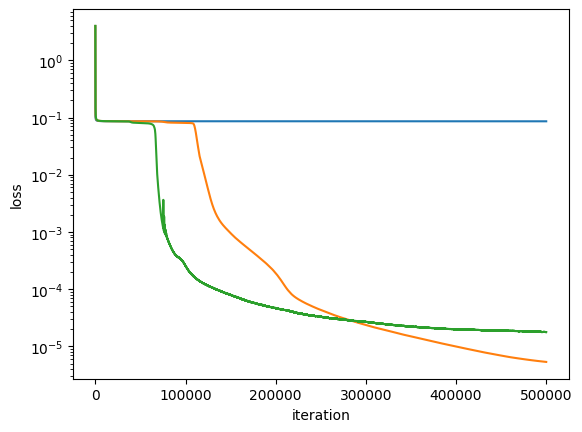

In [117]:
## 全连接网络
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std= 10**(-2))
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
iterations=round(5*10**(5))
xx=np.linspace(1,iterations+1,iterations)
net1 = Net1(1,50,1,linear=False)
net1.apply(weights_init)
net1 = net1.to(device)
optimizer1 = torch.optim.SGD(net1.parameters(),lr = 0.005)
all_loss1 = []
net2 = CNN1(1,50,1,linear=False) 
net2.apply(weights_init)
net2=net2.to(device)    
optimizer2 = torch.optim.SGD(net2.parameters(),lr = 0.005)
all_loss2=[]
net3 = CNN5(1,50,1,linear=False) 
net3.apply(weights_init)
net3=net3.to(device)    
optimizer3 = torch.optim.SGD(net3.parameters(),lr = 0.005)
all_loss3=[]
mpc1 = []
mpc2 = []
mpc3 = []
para=np.zeros((iterations,3))
all_data1 = np.array([]).reshape(0,1)
all_data2 = np.array([]).reshape(0,1)
all_data3 = np.array([]).reshape(0,1)
for t in tqdm(range(iterations)):
    if t%20==0:
        mpc1.append(net3.MPC1(x.to(device)).item())
        mpc2.append(net3.MPC2(x.to(device)).item())
        mpc3.append(net3.MPC3(x.to(device)).item())
    if t%1000==0:
        data1 = net1(x1.to(device))
        data1=data1.cpu()
        data1 = data1.detach()
        all_data1 = np.concatenate((all_data1, data1), axis=0)
        data2 = net2(x1.to(device))
        data2=data2.cpu()
        data2 = data2.detach()
        all_data2 = np.concatenate((all_data2, data2), axis=0)
        data3 = net3(x1.to(device))
        data3=data3.cpu()
        data3 = data3.detach()
        all_data3 = np.concatenate((all_data3, data3), axis=0)
    net1 = net1.to(device)
    prediction1 = net1(x.to(device))
    loss1 = loss_func(prediction1, y.to(device))
    all_loss1.append(loss1.item())
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()  
    net2 = net2.to(device)
    prediction2 = net2(x.to(device))
    loss2 = loss_func(prediction2, y.to(device))
    all_loss2.append(loss2.item())
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step() 
    net3=net3.to(device)
    prediction3 = net3(x.to(device))
    loss3 = loss_func(prediction3,y.to(device))
    all_loss3.append(loss3.item())
    optimizer3.zero_grad()
    loss3.backward()
    optimizer3.step()  
    pass    

# 将列表转换为 NumPy 数组
mpc1_array = np.array(mpc1)
mpc2_array = np.array(mpc2)
mpc3_array = np.array(mpc3)
matrix = np.vstack([mpc1_array, mpc2_array, mpc3_array])
np.save(r'D:\learning\graduation design\trainingdata2\mpc_matrix.npy', matrix)
np.save(r'D:\learning\graduation design\trainingdata2\all_loss1',all_loss1)
np.save(r'D:\learning\graduation design\trainingdata2\all_loss2',all_loss2)
np.save(r'D:\learning\graduation design\trainingdata2\all_loss3',all_loss3)
np.save(r'D:\learning\graduation design\trainingdata2\all_data1.npy', all_data1)
np.save(r'D:\learning\graduation design\trainingdata2\all_data2.npy', all_data2)
np.save(r'D:\learning\graduation design\trainingdata2\all_data3.npy', all_data3)
plt.plot(xx, all_loss1)
plt.plot(xx, all_loss2)
plt.plot(xx, all_loss3)
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('loss')

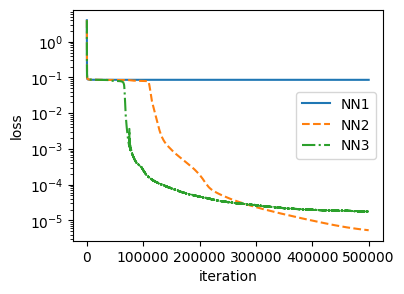

In [118]:
plt.figure(figsize=(4, 3))
plt.plot(xx, all_loss1,label='NN1')
plt.plot(xx, all_loss2, linestyle='--',label='NN2')
plt.plot(xx, all_loss3, linestyle='-.',label='NN3')
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

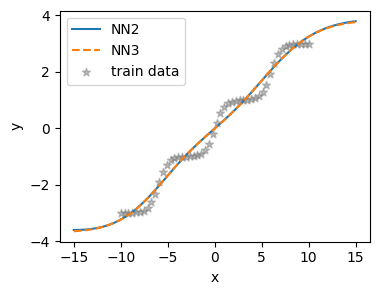

In [122]:
# 假设每个epoch生成的数据有50行
len_per_epoch = 50

# 第i个epoch的数据索引范围
#第二个网络147有奇效
start = 100 * len_per_epoch
end = start + len_per_epoch

start1 = 50 * len_per_epoch
end1 = start1 + len_per_epoch
# 取出第i个epoch的数据
data_2i = all_data2[start:end]
data_3i = all_data3[start1:end1]
plt.figure(figsize=(4, 3))
plt.plot(x1,data_2i,label='NN2')
plt.plot(x1,data_3i,linestyle='--',label='NN3')
plt.scatter(x.data,y.data,alpha=0.5, marker='*', label='train data',color='gray')
# plt.plot(x_plot,y_plot,label='y=tanh(x-6)+tanh(x)+tanh(x+6)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


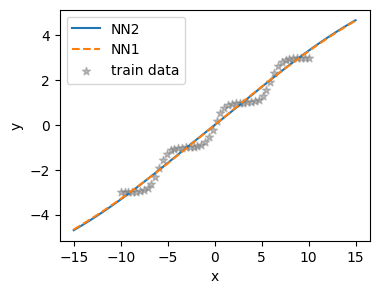

In [107]:
# 假设每个epoch生成的数据有50行
len_per_epoch = 50

# 第i个epoch的数据索引范围
#第二个网络147有奇效
start = 30 * len_per_epoch
end = start + len_per_epoch

start1 = 40 * len_per_epoch
end1 = start1 + len_per_epoch
# 取出第i个epoch的数据
data_2i = all_data2[start:end]
data_i = all_data1[start1:end1]
plt.figure(figsize=(4, 3))
plt.plot(x1,data_2i,label='NN2')
plt.plot(x1,data_i,linestyle='--',label='NN1')
plt.scatter(x.data,y.data,alpha=0.5, marker='*', label='train data',color='gray')
# plt.plot(x_plot,y_plot,label='y=tanh(x-6)+tanh(x)+tanh(x+6)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

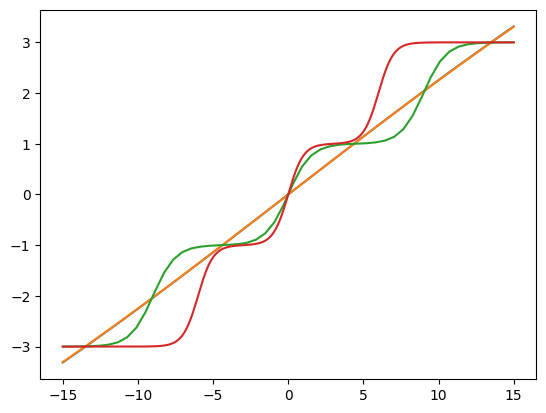

In [81]:
ha1=prediction1.cpu()
ha1 = ha1.detach()
plt.plot(x1,ha1.numpy())
ha2=prediction2.cpu()
ha2 = ha2.detach()
plt.plot(x1,ha2.numpy())
ha3=prediction3.cpu()
ha3= ha3.detach()
plt.plot(x1,ha3.numpy())
plt.plot(x_plot,y_plot,label='y=tanh(x-6)+tanh(x)+tanh(x+6)')

In [61]:
matrix.shape

(3, 25000)

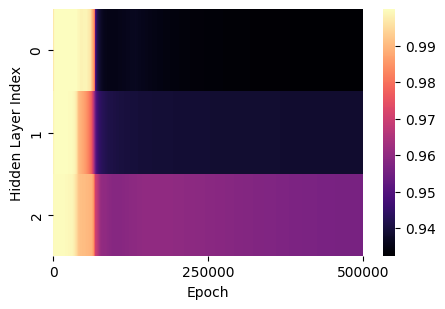

In [123]:
plt.figure(figsize=(5, 3.2))
ax = sns.heatmap(matrix,cmap='magma')
ax.set_ylabel('Hidden Layer Index')
ax.set_xlabel('Epoch')
ax.set_xticks([0, len(matrix[0])//2, len(matrix[0])-1])
ax.set_xticklabels(['0', '250000', '500000'],rotation=0)
plt.show()

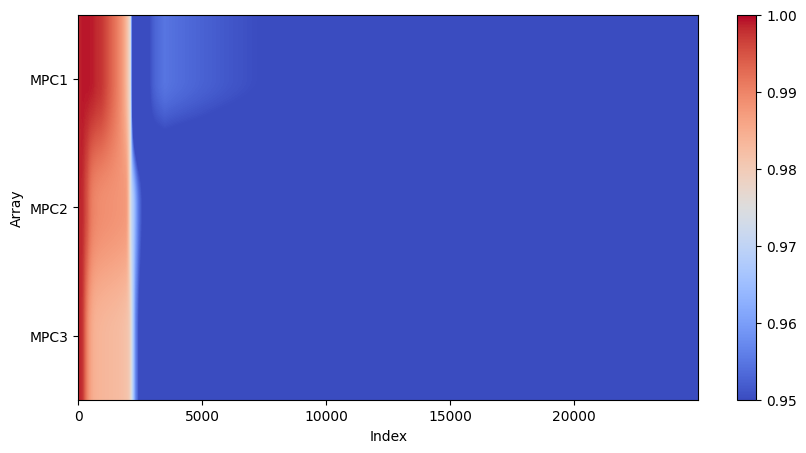

In [57]:


# 绘制热力图
plt.figure(figsize=(10, 5))  # 设置图像大小
plt.imshow(matrix, aspect='auto', cmap='coolwarm', vmin=0.95, vmax=1)
plt.colorbar()  # 显示颜色条

# 设置坐标轴标签
plt.xlabel('Index')
plt.ylabel('Array')

# 设置纵轴的刻度标签，表示两个数组
plt.yticks([0, 1,2], ['MPC1', 'MPC2','MPC3'])

plt.show()

In [65]:
c22 = net2.state_dict()
print(c22)

OrderedDict([('l1.weight', tensor([[ 0.0277],
        [-0.0272],
        [-0.0237],
        [ 0.0227],
        [-0.0184],
        [ 0.0242],
        [-0.0234],
        [-0.0218],
        [ 0.0244],
        [-0.0222],
        [-0.0210],
        [ 0.0227],
        [-0.0216],
        [ 0.0224],
        [-0.0207],
        [ 0.0221],
        [-0.0271],
        [ 0.0006],
        [ 0.0260],
        [-0.0224],
        [ 0.0220],
        [-0.0212],
        [ 0.0222],
        [-0.0216],
        [ 0.0223],
        [-0.0204],
        [ 0.0231],
        [-0.0210],
        [ 0.0213],
        [-0.0249],
        [ 0.0258],
        [ 0.0295],
        [-0.0209],
        [ 0.0220],
        [-0.0211],
        [ 0.0232],
        [-0.0237],
        [-0.0206],
        [ 0.0227],
        [-0.0216],
        [ 0.0226],
        [-0.0202],
        [ 0.0224],
        [-0.0268],
        [-0.0068],
        [ 0.0251],
        [-0.0216],
        [ 0.0214],
        [-0.0232],
        [ 0.0234]], device='cuda:0')), ('l

下面是调整数据集大小的实验

100%|██████████| 80000/80000 [06:00<00:00, 221.75it/s]


Text(0, 0.5, 'loss')

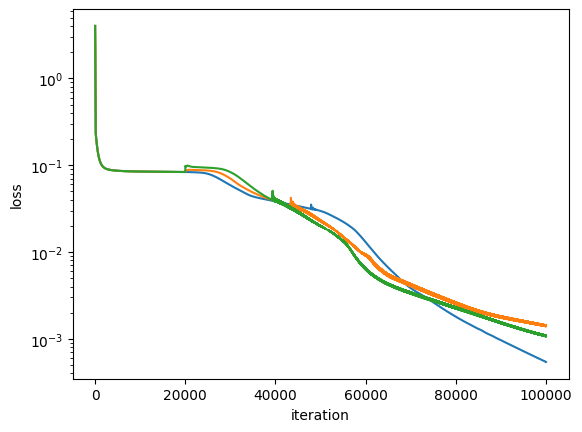

In [29]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std= 10**(-1))
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
iterations=round(2*10**(4))
xx=np.linspace(1,5*iterations+1,5*iterations)
net = CNN5(1,50,1,linear=False) 
net.apply(weights_init)
net=net.to(device)    
optimizer = torch.optim.SGD(net.parameters(),lr = 0.002)
all_loss=[]
all_loss1=[]
all_loss2=[]
para=np.zeros((iterations,3))
all_data1 = np.array([]).reshape(0,1)
mpc11, mpc12, mpc13 = [], [], []
mpc21, mpc22, mpc23 = [], [], []
mpc31, mpc32, mpc33 = [], [], []
for t in tqdm(range(iterations)): 
    # if t%20==0:
    #     tmp1 = net.MPC1(x.to(device)).item()
    #     tmp2 = net.MPC2(x.to(device)).item()
    #     tmp3 = net.MPC3(x.to(device)).item()
    #     mpc11.append(tmp1)
    #     mpc12.append(tmp2)
    #     mpc13.append(tmp3)  
    #     mpc21.append(tmp1)
    #     mpc22.append(tmp2)
    #     mpc23.append(tmp3)  
    #     mpc31.append(tmp1)
    #     mpc32.append(tmp2)
    #     mpc33.append(tmp3)   
    if t%1000==0:
        data1 = net(x1.to(device))
        data1=data1.cpu()
        data1 = data1.detach()
        all_data1 = np.concatenate((all_data1, data1), axis=0)      
    net=net.to(device)
    prediction = net(x.to(device))
    loss = loss_func(prediction,y.to(device))
    all_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()   
    pass
net1 = CNN5(1,50,1,linear=False) 
net2 = CNN5(1,50,1,linear=False)  
net1.load_state_dict(net.state_dict())
net2.load_state_dict(net.state_dict())
net1=net1.to(device)    
optimizer1 = torch.optim.SGD(net1.parameters(),lr = 0.002)
net2=net2.to(device)    
optimizer2 = torch.optim.SGD(net2.parameters(),lr = 0.002)
all_loss1 = all_loss.copy()
all_loss2 = all_loss.copy()
x11 = torch.unsqueeze(torch.linspace(-11,11,55,dtype=dtype),dim=1)
y11 = fstar(x11)
x12 = torch.unsqueeze(torch.linspace(-12,12,60,dtype=dtype),dim=1)
y12 = fstar(x12)
for t in tqdm(range(iterations, 5 * iterations)): 
    # if t%20==0:
    #     mpc11.append(net.MPC1(x.to(device)).item())
    #     mpc12.append(net.MPC2(x.to(device)).item())
    #     mpc13.append(net.MPC3(x.to(device)).item())
    #     mpc21.append(net1.MPC1(x.to(device)).item())
    #     mpc22.append(net1.MPC2(x.to(device)).item())
    #     mpc23.append(net1.MPC3(x.to(device)).item())
    #     mpc31.append(net2.MPC1(x.to(device)).item())
    #     mpc32.append(net2.MPC2(x.to(device)).item())
    #     mpc33.append(net2.MPC3(x.to(device)).item())
    if t%1000==0:
        data1 = net(x1.to(device))
        data1=data1.cpu()
        data1 = data1.detach()
        all_data1 = np.concatenate((all_data1, data1), axis=0)
    net=net.to(device)
    prediction = net(x.to(device))
    loss = loss_func(prediction,y.to(device))
    all_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 
    net1=net1.to(device)
    prediction1 = net1(x11.to(device))
    loss1 = loss_func(prediction1,y11.to(device))
    prediction11 = net1(x.to(device))
    loss11 = loss_func(prediction11,y.to(device))
    all_loss1.append(loss11.item())
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()   
    net2=net2.to(device)
    prediction2 = net2(x12.to(device))
    loss2 = loss_func(prediction2,y12.to(device))
    prediction22 = net2(x.to(device))
    loss22 = loss_func(prediction22,y.to(device))
    all_loss2.append(loss22.item())
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step() 
    pass
# mpc11_array = np.array(mpc11)
# mpc12_array = np.array(mpc12)
# mpc13_array = np.array(mpc13)
# matrix1 = np.vstack([mpc11_array, mpc12_array, mpc13_array])
# mpc21_array = np.array(mpc21)
# mpc22_array = np.array(mpc22)
# mpc23_array = np.array(mpc23)
# matrix2 = np.vstack([mpc21_array, mpc22_array, mpc23_array])
# mpc31_array = np.array(mpc31)
# mpc32_array = np.array(mpc32)
# mpc33_array = np.array(mpc33)
# matrix3 = np.vstack([mpc31_array, mpc32_array, mpc33_array])
plt.plot(xx,all_loss)
plt.plot(xx,all_loss1)
plt.plot(xx,all_loss2)
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('loss')

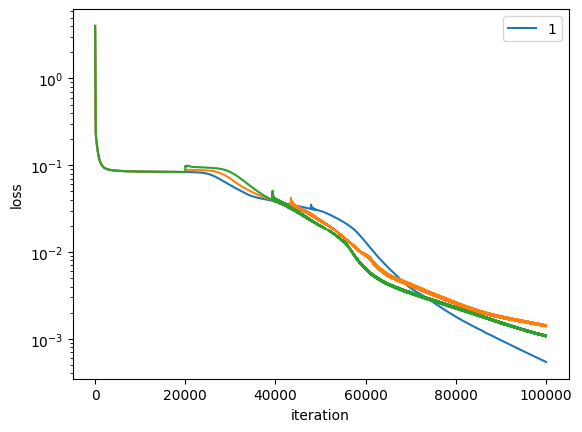

In [35]:
plt.plot(xx,all_loss,label='1')
plt.plot(xx,all_loss1)
plt.plot(xx,all_loss2)
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

In [24]:
x1.shape

torch.Size([55, 1])

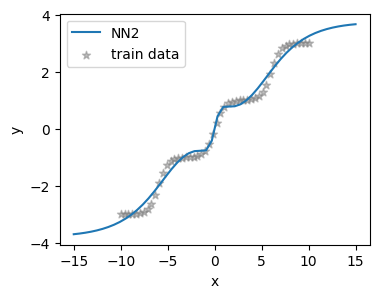

In [34]:
# 假设每个epoch生成的数据有50行
len_per_epoch = 50

# 第i个epoch的数据索引范围
#第二个网络147有奇效
start = 40 * len_per_epoch
end = start + len_per_epoch

data_2i = all_data1[start:end]
plt.figure(figsize=(4, 3))
plt.plot(x1,data_2i,label='NN2')
plt.scatter(x.data,y.data,alpha=0.5, marker='*', label='train data',color='gray')
# plt.plot(x_plot,y_plot,label='y=tanh(x-6)+tanh(x)+tanh(x+6)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [68]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std= 10**(-1))
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
iterations=round(6*10**(4))
xx=np.linspace(1,3*iterations+1,3*iterations)
net = CNN1(1,10,1,linear=False) 
net.apply(weights_init)
net=net.to(device)    
optimizer = torch.optim.SGD(net.parameters(),lr = 0.002)
all_loss=[]
all_loss1=[]
all_loss2=[]
para=np.zeros((iterations,3))
all_data1 = np.array([]).reshape(0,1)
mpc11, mpc12= [], []
mpc21, mpc22= [], []
mpc31, mpc32= [], []
for t in tqdm(range(iterations)): 
    if t%20==0:
        tmp1 = net.MPC1(x.to(device)).item()
        tmp2 = net.MPC2(x.to(device)).item()
    #     tmp3 = net.MPC3(x.to(device)).item()
        mpc11.append(tmp1)
        mpc12.append(tmp2)
    #     mpc13.append(tmp3)  
        mpc21.append(tmp1)
        mpc22.append(tmp2)
    #     mpc23.append(tmp3)  
        mpc31.append(tmp1)
        mpc32.append(tmp2)
    #     mpc33.append(tmp3)   
    if t%1000==0:
        data1 = net(x1.to(device))
        data1=data1.cpu()
        data1 = data1.detach()
        all_data1 = np.concatenate((all_data1, data1), axis=0)      
    net=net.to(device)
    prediction = net(x.to(device))
    loss = loss_func(prediction,y.to(device))
    all_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()   
    pass
net1 = CNN1(1,10,1,linear=False) 
net2 = CNN1(1,10,1,linear=False)  
net1.load_state_dict(net.state_dict())
net2.load_state_dict(net.state_dict())
net1=net1.to(device)    
optimizer1 = torch.optim.SGD(net1.parameters(),lr = 0.002)
net2=net2.to(device)    
optimizer2 = torch.optim.SGD(net2.parameters(),lr = 0.002)
all_loss1 = all_loss.copy()
all_loss2 = all_loss.copy()
x11 = torch.unsqueeze(torch.linspace(-11,11,55,dtype=dtype),dim=1)
y11 = fstar(x11)
x12 = torch.unsqueeze(torch.linspace(-12,12,60,dtype=dtype),dim=1)
y12 = fstar(x12)
for t in tqdm(range(iterations, 3 * iterations)): 
    if t%20==0:
        mpc11.append(net.MPC1(x.to(device)).item())
        mpc12.append(net.MPC2(x.to(device)).item())
    #     mpc13.append(net.MPC3(x.to(device)).item())
        mpc21.append(net1.MPC1(x.to(device)).item())
        mpc22.append(net1.MPC2(x.to(device)).item())
    #     mpc23.append(net1.MPC3(x.to(device)).item())
        mpc31.append(net2.MPC1(x.to(device)).item())
        mpc32.append(net2.MPC2(x.to(device)).item())
    #     mpc33.append(net2.MPC3(x.to(device)).item())
    if t%1000==0:
        data1 = net(x1.to(device))
        data1=data1.cpu()
        data1 = data1.detach()
        all_data1 = np.concatenate((all_data1, data1), axis=0)
    net=net.to(device)
    prediction = net(x.to(device))
    loss = loss_func(prediction,y.to(device))
    all_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 
    net1=net1.to(device)
    prediction1 = net1(x11.to(device))
    loss1 = loss_func(prediction1,y11.to(device))
    prediction11 = net1(x.to(device))
    loss11 = loss_func(prediction11,y.to(device))
    all_loss1.append(loss11.item())
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()   
    net2=net2.to(device)
    prediction2 = net2(x12.to(device))
    loss2 = loss_func(prediction2,y12.to(device))
    prediction22 = net2(x.to(device))
    loss22 = loss_func(prediction22,y.to(device))
    all_loss2.append(loss22.item())
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step() 
    pass
mpc11_array = np.array(mpc11)
mpc12_array = np.array(mpc12)
# mpc13_array = np.array(mpc13)
matrix1 = np.vstack([mpc11_array, mpc12_array])
mpc21_array = np.array(mpc21)
mpc22_array = np.array(mpc22)
# mpc23_array = np.array(mpc23)
matrix2 = np.vstack([mpc21_array, mpc22_array])
mpc31_array = np.array(mpc31)
mpc32_array = np.array(mpc32)
# mpc33_array = np.array(mpc33)
matrix3 = np.vstack([mpc31_array, mpc32_array])

  0%|          | 0/60000 [00:00<?, ?it/s]

100%|██████████| 120000/120000 [07:47<00:00, 256.82it/s]


ValueError: x and y must have same first dimension, but have shapes (180000,) and (160000,)

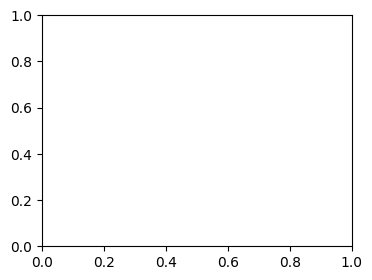

In [79]:
plt.figure(figsize=(4, 3))
plt.plot(xx,all_loss,label='datasize=50')
plt.plot(xx,all_loss1,label='datasize=55')
# plt.plot(xx,all_loss2,label='datasize=60')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [65]:
np.save(r'D:\learning\graduation design\data1\mpc_matrix1.npy', matrix1)
np.save(r'D:\learning\graduation design\data1\mpc_matrix2.npy', matrix2)
np.save(r'D:\learning\graduation design\data1\mpc_matrix3.npy', matrix3)
np.save(r'D:\learning\graduation design\data1\all_loss1',all_loss1)
np.save(r'D:\learning\graduation design\data1\all_loss2',all_loss2)
np.save(r'D:\learning\graduation design\data1\all_loss',all_loss)

In [76]:
matrix1 = np.load('D:\learning\graduation design\data1\mpc_matrix1.npy')
matrix2 = np.load('D:\learning\graduation design\data1\mpc_matrix2.npy')
matrix3 = np.load('D:\learning\graduation design\data1\mpc_matrix3.npy')
all_loss = np.load('all_loss.npy')
all_loss1 = np.load('all_loss1.npy')
all_loss2 = np.load('all_loss2.npy')

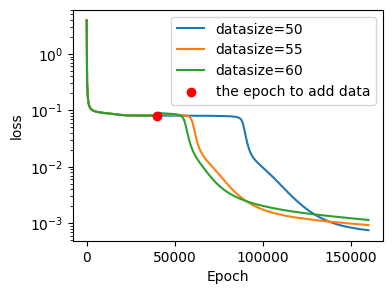

In [85]:
xx=np.linspace(1,160001,160000)
x_value = 40000
y_value = all_loss[x_value]
plt.figure(figsize=(4, 3))
plt.plot(xx,all_loss,label='datasize=50')
plt.plot(xx,all_loss1,label='datasize=55')
plt.plot(xx,all_loss2,label='datasize=60')
plt.scatter(x_value, y_value, color='red', zorder=10,label='the epoch to add data')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

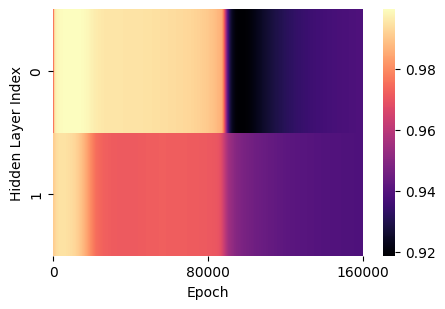

In [86]:
plt.figure(figsize=(5, 3.2))
ax = sns.heatmap(matrix1,cmap='magma')
ax.set_ylabel('Hidden Layer Index')
ax.set_xlabel('Epoch')
ax.set_xticks([0, len(matrix1[0])//2, len(matrix1[0])-1])
ax.set_xticklabels(['0', '80000', '160000'],rotation=0)
plt.show()

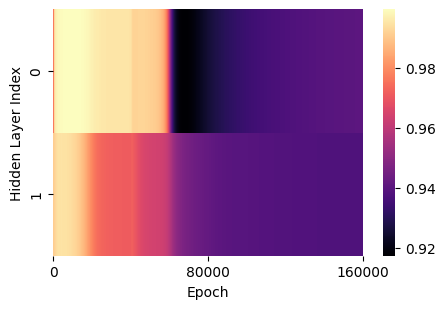

In [87]:
plt.figure(figsize=(5, 3.2))
ax = sns.heatmap(matrix2,cmap='magma')
ax.set_ylabel('Hidden Layer Index')
ax.set_xlabel('Epoch')
ax.set_xticks([0, len(matrix2[0])//2, len(matrix2[0])-1])
ax.set_xticklabels(['0', '80000', '160000'],rotation=0)
plt.show()

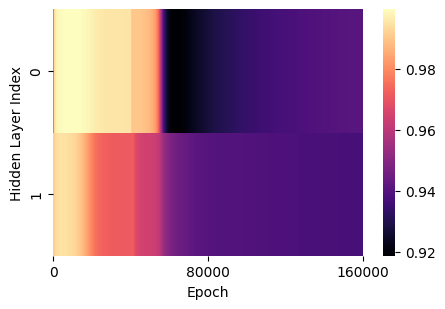

In [88]:
plt.figure(figsize=(5, 3.2))
ax = sns.heatmap(matrix3,cmap='magma')
ax.set_ylabel('Hidden Layer Index')
ax.set_xlabel('Epoch')
ax.set_xticks([0, len(matrix3[0])//2, len(matrix3[0])-1])
ax.set_xticklabels(['0', '80000', '160000'],rotation=0)
plt.show()

下面的实验是展示卷积层和卷积层之间合并的实验

100%|██████████| 100000/100000 [04:00<00:00, 415.55it/s]


Text(0, 0.5, 'loss')

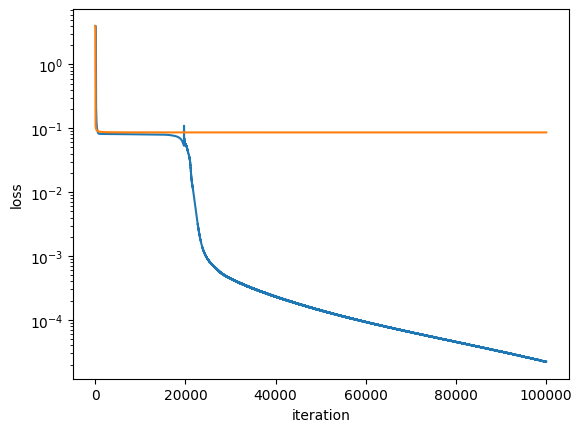

In [89]:
## 四个卷积层的对应实验
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std= 10**(-2))
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
iterations=round(10**(5))
xx=np.linspace(1,iterations+1,iterations)
net1 = Net1(1,50,1,linear=False)
net1.apply(weights_init)
net1 = net1.to(device)
optimizer1 = torch.optim.SGD(net1.parameters(),lr = 0.01)
all_loss1 = []
net3 = CNN6(1,50,1,linear=False) 
net3.apply(weights_init)
net3=net3.to(device)    
optimizer3 = torch.optim.SGD(net3.parameters(),lr = 0.01)
all_loss3=[]
mpc1 = []
mpc2 = []
mpc3 = []
mpc4 = []
mpc5 = []
para=np.zeros((iterations,3))
for t in tqdm(range(iterations)):
    if t%20==0:
        mpc1.append(net3.MPC1(x.to(device)).item())
        mpc2.append(net3.MPC2(x.to(device)).item())
        mpc3.append(net3.MPC3(x.to(device)).item())
        mpc4.append(net3.MPC4(x.to(device)).item())
        mpc5.append(net3.MPC5(x.to(device)).item())
    net1 = net1.to(device)
    prediction1 = net1(x.to(device))
    loss1 = loss_func(prediction1, y.to(device))
    all_loss1.append(loss1.item())
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()  
    net3=net3.to(device)
    prediction3 = net3(x.to(device))
    loss3 = loss_func(prediction3,y.to(device))
    all_loss3.append(loss3.item())
    optimizer3.zero_grad()
    loss3.backward()
    optimizer3.step()  
    pass    


plt.plot(xx, all_loss3)
plt.plot(xx, all_loss1)
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel('loss')

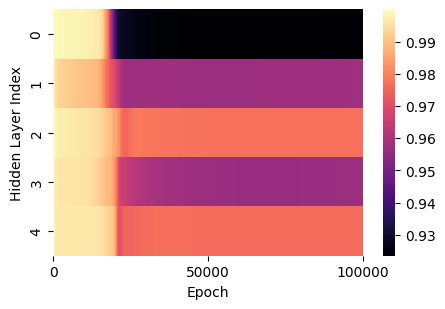

In [93]:
# 将列表转换为 NumPy 数组
mpc1_array = np.array(mpc1)
mpc2_array = np.array(mpc2)
mpc3_array = np.array(mpc3)
mpc4_array = np.array(mpc4)
mpc5_array = np.array(mpc5)

# 垂直堆叠这两个数组
matrix = np.vstack([mpc1_array, mpc2_array, mpc3_array,mpc4_array,mpc5_array])

# 绘制热力图
plt.figure(figsize=(5,3.2))  # 设置图像大小
ax = sns.heatmap(matrix,cmap='magma')
ax.set_ylabel('Hidden Layer Index')
ax.set_xlabel('Epoch')
ax.set_xticks([0, len(matrix[0])//2, len(matrix[0])-1])
ax.set_xticklabels(['0', '50000', '100000'],rotation=0)
plt.show()

### 增加层数对特征值的影响